In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import re
import tqdm
import os
from collections import defaultdict

In [2]:
plt.rcParams.update({
    'figure.figsize': (6, 4),            # Figure size
    'figure.dpi': 100,                   # High DPI for publication-quality images
    'axes.titlesize': 14,                # Title font size
    'axes.labelsize': 12,                # Axis label font size
    'axes.labelpad': 10,                 # Padding for labels
    'axes.linewidth': 1,                 # Axis line width
    'axes.grid': False,                  # Disable grid unless necessary
    'xtick.labelsize': 10,               # X-axis tick label size
    'ytick.labelsize': 10,               # Y-axis tick label size
    'xtick.major.size': 4,               # Length of major ticks
    'ytick.major.size': 4,               # Length of major ticks
    'xtick.major.width': 1,              # Width of major ticks
    'ytick.major.width': 1,              # Width of major ticks
    'xtick.direction': 'in',             # Ticks facing inwards
    'ytick.direction': 'in',             # Ticks facing inwards
    'legend.fontsize': 10,               # Legend font size
    'legend.frameon': False,             # Disable legend frame for a cleaner look
    'font.family': 'serif',              # Use a serif font for text
    'font.serif': ['DejaVu Serif'],      # Use 'DejaVu Serif' as the fallback serif font
    'lines.linewidth': 1.5,              # Line width for plots
    'lines.markersize': 6,               # Marker size
    'savefig.dpi': 300,                  # Save figure resolution
    'savefig.bbox': 'tight',             # Adjust layout to avoid clipping
})

model_map = {'google_gemma-2-2b': 'Gemma-2-2B', 'google_gemma-2-2b-it': 'Gemma-2B-Instruct', 'microsoft_phi-2': 'Phi-2', 'meta-llama_Llama-3.1-8B': 'Llama3.1-8B', 'meta-llama_Llama-3.1-8B-Instruct': 'Llama3.1-8B-Instruct', 'microsoft_Phi-3.5-mini-instruct': 'Phi-3.5-mini-Instruct', 'allenai_OLMoE-1B-7B-0924': 'OLMoE-1B-7B-0924', 'mistralai_Mistral-7B-v0.3': 'Mistral-7B', 'mistralai_Mistral-7B-Instruct-v0.3': 'Mistral-7B-Instruct', 'allenai_OLMoE-1B-7B-0924-Instruct': 'OLMoE-1B-7B-0924-Instruct'}

model_color_map = {
    'google_gemma-2-2b': 'tab:blue',
    'google_gemma-2-2b-it': 'tab:orange',
    'microsoft_phi-2': 'tab:green',
    'meta-llama_Llama-3.1-8B': 'tab:red',
    'meta-llama_Llama-3.1-8B-Instruct': 'tab:purple',
    'microsoft_Phi-3.5-mini-instruct': 'tab:cyan',
    'allenai_OLMoE-1B-7B-0924': 'tab:pink',
    'mistralai_Mistral-7B-v0.3': 'tab:gray',
    'mistralai_Mistral-7B-Instruct-v0.3': 'tab:olive'
}

In [6]:
# Load the stats data from the folder
model_keys = [
    '/home/rcorona/2024/random_needle/exps/contextual/posterior_chain_coin_flip/icl_0/no_bias/google_gemma-2-2b',
    '/home/rcorona/2024/random_needle/exps/contextual/posterior_chain_coin_flip/icl_0/no_bias/meta-llama_Llama-3.1-8B',
    '/home/rcorona/2024/random_needle/exps/contextual/posterior_chain_coin_flip/icl_0/no_bias/microsoft_phi-2',
    '/home/rcorona/2024/random_needle/exps/contextual/posterior_chain_coin_flip/icl_0/no_bias/mistralai_Mistral-7B-v0.3',
    '/home/rcorona/2024/random_needle/exps/contextual/posterior_chain_coin_flip/icl_0/no_bias/allenai_OLMoE-1B-7B-0924',
    #'/home/rcorona/2024/random_needle/exps/contextual/posterior_chain_coin_flip/icl_0/no_bias/allenai_OLMoE-1B-7B-0924-Instruct',
    '/home/rcorona/2024/random_needle/exps/contextual/posterior_chain_coin_flip/icl_0/no_bias/google_gemma-2-2b-it',
    '/home/rcorona/2024/random_needle/exps/contextual/posterior_chain_coin_flip/icl_0/no_bias/meta-llama_Llama-3.1-8B-Instruct',
    '/home/rcorona/2024/random_needle/exps/contextual/posterior_chain_coin_flip/icl_0/no_bias/microsoft_Phi-3.5-mini-instruct',
    '/home/rcorona/2024/random_needle/exps/contextual/posterior_chain_coin_flip/icl_0/no_bias/mistralai_Mistral-7B-Instruct-v0.3'
    # '/home/rcorona/2024/random_needle/exps/contextual/coin_flip/google_gemma-2-2b',
    # '/home/rcorona/2024/random_needle/exps/contextual/coin_flip/meta-llama_Llama-3.1-8B',
    # '/home/rcorona/2024/random_needle/exps/contextual/coin_flip/microsoft_phi-2',
    # '/home/rcorona/2024/random_needle/exps/contextual/coin_flip/mistralai_Mistral-7B-v0.3',
    # '/home/rcorona/2024/random_needle/exps/contextual/coin_flip/allenai_OLMoE-1B-7B-0924',
    # '/home/rcorona/2024/random_needle/exps/contextual/coin_flip/allenai_OLMoE-1B-7B-0924-Instruct',
    # '/home/rcorona/2024/random_needle/exps/contextual/coin_flip/google_gemma-2-2b-it',
    # '/home/rcorona/2024/random_needle/exps/contextual/coin_flip/meta-llama_Llama-3.1-8B-Instruct',
    # '/home/rcorona/2024/random_needle/exps/contextual/coin_flip/microsoft_Phi-3.5-mini-instruct',
    # '/home/rcorona/2024/random_needle/exps/contextual/coin_flip/mistralai_Mistral-7B-Instruct-v0.3'
]

model_stats_data = {}
for key in tqdm.tqdm(model_keys):
    if os.path.exists(f'{key}/stats.pkl'):
        with open(f'{key}/stats.pkl', 'rb') as f:
            model_stats_data[key.split('/')[-1]] = pickle.load(f)

#icl_data['averaged_stats']['biased_point'][f'When I flip coins they land on heads {bias}% of the time.']['tvd']['mean']

100%|██████████| 9/9 [00:00<00:00, 419.30it/s]


In [4]:
print(model_stats_data['google_gemma-2-2b']['averaged_stats']['biased_point']['']['choice_probs']['all'].shape)

(50, 2)


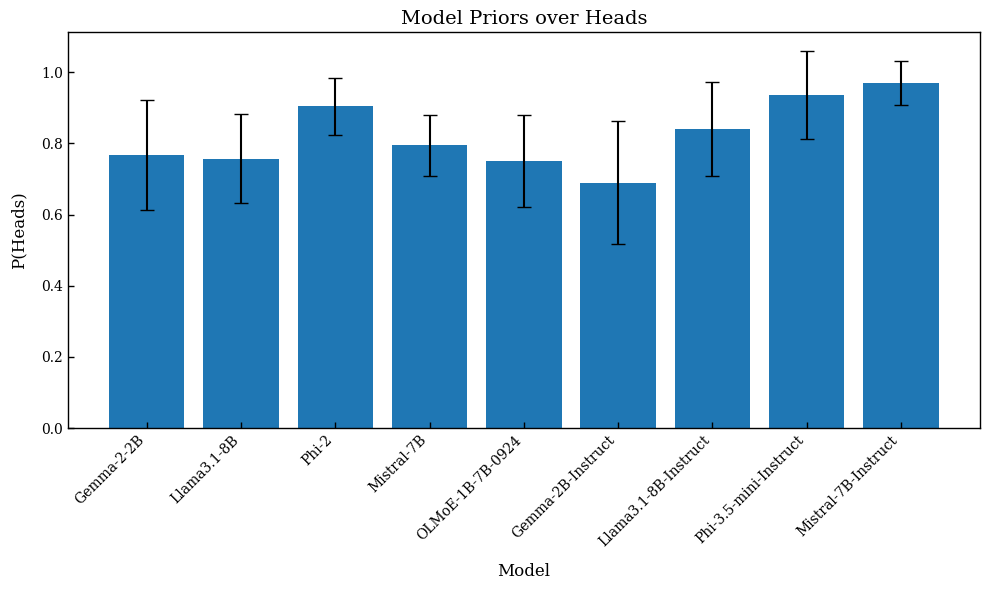

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming model_stats_data is already defined

# Extract model names, means, and stds
models = []
means = []
stds = []

for key in model_stats_data.keys():
    model_name = key.split('/')[-1]
    heads_mean = np.mean(model_stats_data[model_name]['averaged_stats']['biased_point']['']['choice_probs']['all'][:,0])
    heads_std = np.std(model_stats_data[model_name]['averaged_stats']['biased_point']['']['choice_probs']['all'][:,0])
    #tvd_mean = model_stats_data[model_name]['averaged_stats']['biased_point']['']['tvd']['mean']
    #tvd_std = model_stats_data[model_name]['averaged_stats']['biased_point']['']['tvd']['std']
    
    models.append(model_name)
    means.append(heads_mean)
    stds.append(heads_std)

# Convert to numpy arrays
means = np.array(means)
stds = np.array(stds)

# X labels based on model names map. 
models = [model_map[model] for model in models]

# Plotting
plt.figure(figsize=(10, 6))

plt.bar(models, means, yerr=stds, capsize=5)
plt.xlabel('Model')
plt.ylabel('P(Heads)')
plt.title('Model Priors over Heads')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Write to pdf. 
plt.savefig('model_priors.pdf')

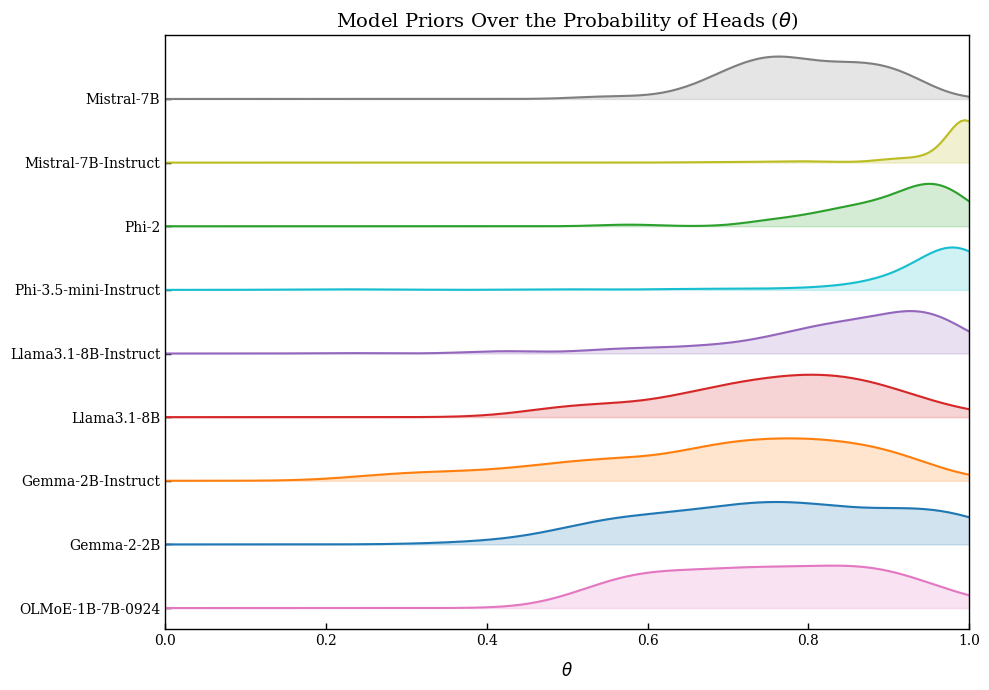

In [29]:
from scipy.stats import gaussian_kde

all_model_keys = sorted(model_stats_data.keys())

offset_step = 0.6  # vertical spacing between distributions
yticks_positions = []
yticks_labels = []

plt.figure(figsize=(10, 7))

for i, full_key in enumerate(all_model_keys):
    model_key = full_key.split('/')[-1]

    heads_probs = model_stats_data[model_key]['averaged_stats']['biased_point']['']['choice_probs']['all'][:, 0]

    x_vals = np.linspace(0, 1, 200)
    kde = gaussian_kde(heads_probs, bw_method='scott')
    density = kde(x_vals)

    max_density = np.max(density)
    density_scaled = (density / max_density) * 0.4

    distribution_offset = i * offset_step

    color = model_color_map[model_key]
    plt.plot(x_vals, density_scaled + distribution_offset,
             label=model_map.get(model_key, model_key),
             color=color)
    
    plt.fill_between(x_vals, distribution_offset,
                     density_scaled + distribution_offset,
                     alpha=0.2, color=color)

    yticks_positions.append(distribution_offset)
    yticks_labels.append(model_map.get(model_key, model_key))

plt.yticks(yticks_positions, yticks_labels)

plt.xlabel('$\\theta$')
plt.xlim(0, 1)

# Margin
plt.ylim(-0.2, yticks_positions[-1] + offset_step)

plt.title('Model Priors Over the Probability of Heads ($\\theta$)')
plt.tight_layout()

plt.savefig('model_priors.pdf')
plt.show()

## Make plotly plot

In [11]:
import os
import json
import pickle
import numpy as np
from scipy.stats import gaussian_kde
import plotly.graph_objects as go
import matplotlib.colors as mcolors

# Example definitions; update these with your actual mappings.
model_color_map = {
    'google_gemma-2-2b': '#1f77b4',
    # 'google_gemma-2-2b-it': '#ff7f0e',
    'microsoft_phi-2': '#2ca02c',
    'meta-llama_Llama-3.1-8B': '#d62728',
    # 'meta-llama_Llama-3.1-8B-Instruct': '#9467bd',
    # 'microsoft_Phi-3.5-mini-instruct': '#17becf',
    'allenai_OLMoE-1B-7B-0924': '#e377c2',
    'mistralai_Mistral-7B-v0.3': '#7f7f7f',
    # 'mistralai_Mistral-7B-Instruct-v0.3': '#bcbd22'
}

model_map = {
    'google_gemma-2-2b': 'Gemma-2-2B',
    # 'google_gemma-2-2b-it': 'Gemma-2B-Instruct',
    'microsoft_phi-2': 'Phi-2',
    'meta-llama_Llama-3.1-8B': 'Llama3.1-8B',
    # 'meta-llama_Llama-3.1-8B-Instruct': 'Llama3.1-8B-Instruct',
    # 'microsoft_Phi-3.5-mini-instruct': 'Phi-3.5-mini-Instruct',
    'allenai_OLMoE-1B-7B-0924': 'OLMoE-1B-7B-0924',
    'mistralai_Mistral-7B-v0.3': 'Mistral-7B',
    # 'mistralai_Mistral-7B-Instruct-v0.3': 'Mistral-7B-Instruct',
    # 'allenai_OLMoE-1B-7B-0924-Instruct': 'OLMoE-1B-7B-0924-Instruct',
}

def convert_color(color_str):
    return mcolors.to_hex(mcolors.get_named_colors_mapping().get(color_str, color_str))

def create_figure_for_bias(target_theta):
    """
    Build and return a Plotly figure for a given bias (target_theta).
    target_theta should be a string (e.g., "20", "50", "70", etc.).
    """
    # ICL lengths to animate over.
    icl_list = list(range(0, 110, 10))
    base_dir = "/home/ritwik/dev/random_needles/exps/contextual/coin_flip_icl_v3"
    
    # List (or order) of models to plot.
    models = [
        'allenai_OLMoE-1B-7B-0924',
        'google_gemma-2-2b',
        'meta-llama_Llama-3.1-8B',
        'microsoft_phi-2',
        # 'mistralai_Mistral-7B-v0.3',
    ]
    
    offset_step = 0.6   # vertical spacing between distributions
    x_vals = np.linspace(0, 1, 200)
    
    # Convert target_theta from string to a float in [0,1]
    target_x = int(target_theta) / 100.0

    frames = []
    for icl in icl_list:
        frame_traces = []
        frame_shapes = []  # shapes for vertical lines in this frame
        
        for i, model in enumerate(models):
            file_path = os.path.join(base_dir, f"icl_{icl}", f"theta_{target_theta}", model, "stats.pkl")
            if not os.path.exists(file_path):
                print(f"Missing file: {file_path}")
                continue

            with open(file_path, 'rb') as f:
                stats = pickle.load(f)

            # Remove unwanted key and select the relevant one.
            del stats['averaged_stats']['biased_point']['tvd_auc']
            target_key = list(stats['averaged_stats']['biased_point'].keys())[-1]
            heads_probs = stats['averaged_stats']['biased_point'][target_key]['choice_probs']['all'][:, 0]
            kde = gaussian_kde(heads_probs, bw_method='scott')
            density = kde(x_vals)
            
            max_density = np.max(density)
            density_scaled = (density / max_density) * 0.4
            
            distribution_offset = i * offset_step
            y_vals = density_scaled + distribution_offset
            
            # Create a polygon to mimic fill_between.
            x_poly = np.concatenate([x_vals, x_vals[::-1]]).tolist()
            y_poly = np.concatenate([y_vals, np.full_like(x_vals, distribution_offset)]).tolist()
            
            trace = go.Scatter(
                x=x_poly,
                y=y_poly,
                fill='toself',
                mode='lines',
                line=dict(color=convert_color(model_color_map[model])),
                name=model_map.get(model, model),
                showlegend=True
            )
            frame_traces.append(trace)
            
            # Compute the mode.
            mode_idx = np.argmax(density)
            mode_x = float(x_vals[mode_idx])
            mode_y = float(density_scaled[mode_idx] + distribution_offset)
            
            mode_line_shape = dict(
                type="line",
                x0=mode_x, x1=mode_x,
                y0=distribution_offset, y1=mode_y,
                line=dict(color="red", dash="dash")
            )
            frame_shapes.append(mode_line_shape)
        
        target_line_shape = dict(
            type="line",
            x0=target_x, x1=target_x,
            y0=0, y1=1,
            xref="x", yref="paper",
            line=dict(color="black", dash="dash")
        )
        frame_shapes.append(target_line_shape)
        
        frames.append(go.Frame(
            data=frame_traces,
            name=str(icl),
            layout=go.Layout(
                title_text=f"Model Priors (icl length = {icl}, bias = {target_theta})",
                shapes=frame_shapes
            )
        ))
    
    if not frames:
        raise ValueError("No frames created. Check your file paths and data.")
    initial_traces = frames[0].data
    
    fig = go.Figure(
        data=initial_traces,
        layout=go.Layout(
            xaxis=dict(range=[0, 1], title="θ"),
            yaxis=dict(title="(Scaled) Density + Offset", showticklabels=False),
            title=f"Model Priors Over the Probability of Heads (θ = {(int(target_theta) / 100):.2f})",
            updatemenus=[dict(
                type="buttons",
                showactive=False,
                y=1,
                x=1.1,
                xanchor="right",
                yanchor="top",
                pad=dict(t=0, r=10),
                buttons=[dict(label="Play",
                              method="animate",
                              args=[None, {"frame": {"duration": 500, "redraw": True},
                                           "fromcurrent": True,
                                           "transition": {"duration": 250}}])]
            )],
            width=1200,
            height=900,
            shapes=frames[0].layout.shapes
        ),
        frames=frames
    )
    
    sliders = [dict(
        steps=[dict(method='animate',
                    args=[[str(icl)],
                          {"frame": {"duration": 500, "redraw": True},
                           "mode": "immediate",
                           "transition": {"duration": 250}}],
                    label=str(icl)) for icl in icl_list],
        transition={"duration": 250},
        x=0, y=0,
        currentvalue=dict(font=dict(size=12), prefix="icl length: ", visible=True, xanchor="center"),
        len=1.0
    )]
    fig.update_layout(sliders=sliders)
    
    return fig

# Generate a dictionary containing the figure specification for each bias.
bias_options = [str(x) for x in range(0, 110, 10)]  # "0", "10", "20", ..., "100"
data_by_bias = {}

for bias in bias_options:
    print("Generating figure for bias:", bias)
    try:
        fig = create_figure_for_bias(bias)
        data_by_bias[bias] = fig.to_dict()
    except Exception as e:
        print("Error generating figure for bias", bias, ":", e)

with open("data.json", "w") as f:
    json.dump(data_by_bias, f, indent=2)

print("data.json created.")


Generating figure for bias: 0
Generating figure for bias: 10
Generating figure for bias: 20
Generating figure for bias: 30
Generating figure for bias: 40
Generating figure for bias: 50
Generating figure for bias: 60
Generating figure for bias: 70
Generating figure for bias: 80
Generating figure for bias: 90
Generating figure for bias: 100
Error generating figure for bias 100 : The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
data.json created.


## Make GIF

In [ ]:
import os
import pickle
import numpy as np
from scipy.stats import gaussian_kde
import plotly.graph_objects as go
import matplotlib.colors as mcolors
import imageio
from PIL import Image
import yaml

def convert_color(color_str):
    return mcolors.to_hex(mcolors.get_named_colors_mapping().get(color_str, color_str))

def load_yaml(filepath):
    with open(filepath, 'r') as f:
        return yaml.safe_load(f)

model_color_map = {
    'google_gemma-2-2b': 'tab:blue',
    'google_gemma-2-2b-it': 'tab:orange',
    'microsoft_phi-2': 'tab:green',
    'meta-llama_Llama-3.1-8B': 'tab:red',
    'meta-llama_Llama-3.1-8B-Instruct': 'tab:purple',
    'microsoft_Phi-3.5-mini-instruct': 'tab:cyan',
    'allenai_OLMoE-1B-7B-0924': 'tab:pink',
    'mistralai_Mistral-7B-v0.3': 'tab:gray',
    'mistralai_Mistral-7B-Instruct-v0.3': 'tab:olive'
}

icl_list = list(range(0, 110, 10))
base_dir = "/home/ritwik/dev/random_needles/exps/contextual/coin_flip_icl_v3"
config_base = "/home/ritwik/dev/random_needles/configs/exps/contextual/coin_flip_icl_v3"
target_theta = "60"

# List of models to plot
models = [
    'allenai_OLMoE-1B-7B-0924',
    # 'allenai_OLMoE-1B-7B-0924-Instruct',
    'google_gemma-2-2b',
    'google_gemma-2-2b-it',
    'meta-llama_Llama-3.1-8B',
    'meta-llama_Llama-3.1-8B-Instruct',
    'microsoft_phi-2',
    'microsoft_Phi-3.5-mini-instruct',
    'mistralai_Mistral-7B-v0.3',
    'mistralai_Mistral-7B-Instruct-v0.3',
]

offset_step = 0.6  # Vertical spacing between distributions
x_vals = np.linspace(0, 1, 200)
target_x = int(target_theta) / 100

os.makedirs("frames", exist_ok=True)
filenames = []

for icl_idx, icl in enumerate(icl_list):
    traces = []
    shapes = []

    # Load the config file for the exp
    config_path = os.path.join(config_base, f"icl_{icl}", f"theta_{target_theta}.yaml")
    if not os.path.exists(config_path):
        print(f"Missing config file: {config_path}")
        continue
    config_data = load_yaml(config_path)
    
    # Get the count of heads and tails in the defined config sequence
    observed_sequence = config_data['input_prompt'][0]
    observed_heads = observed_sequence.count("heads")
    observed_tails = observed_sequence.count("tails")

    # Get the Bayesian posterior
    alpha_prior, beta_prior = 1, 1  # Uniform prior Beta(1,1)
    alpha_post = alpha_prior + observed_heads
    beta_post = beta_prior + observed_tails

    bayesian_samples = np.random.beta(alpha_post, beta_post, 5000)
    bayesian_kde = gaussian_kde(bayesian_samples, bw_method='scott')
    bayesian_density = bayesian_kde(x_vals)

    max_bayesian_density = np.max(bayesian_density)
    bayesian_density_scaled = (bayesian_density / max_bayesian_density) * 0.4

    for i, model in enumerate(models):
        file_path = os.path.join(base_dir, f"icl_{icl}", f"theta_{target_theta}", model, "stats.pkl")
        if not os.path.exists(file_path):
            print(f"Missing file: {file_path}")
            continue

        # Get the actual experiment results
        with open(file_path, 'rb') as f:
            stats = pickle.load(f)

        del stats['averaged_stats']['biased_point']['tvd_auc']  # This does not matter and is always 0.0
        target_key = list(stats['averaged_stats']['biased_point'].keys())[-1]
        heads_probs = stats['averaged_stats']['biased_point'][target_key]['choice_probs']['all'][:, 0]

        # KDE from the TVDs
        kde = gaussian_kde(heads_probs, bw_method='scott')
        density = kde(x_vals)

        max_density = np.max(density)
        density_scaled = (density / max_density) * 0.4

        # Offsets
        distribution_offset = i * offset_step
        y_vals = density_scaled + distribution_offset

        # Fake fill by making a poly
        x_poly = np.concatenate([x_vals, x_vals[::-1]])
        y_poly = np.concatenate([y_vals, np.full_like(x_vals, distribution_offset)])

        trace = go.Scatter(
            x=x_poly,
            y=y_poly,
            fill='toself',
            mode='lines',
            line=dict(color=convert_color(model_color_map[model])),
            name=model,
            showlegend=True
        )
        traces.append(trace)

        # Plot Bayesian posterior
        bayesian_y_vals = bayesian_density_scaled + distribution_offset

        show_bayesian_legend = (i == 0)  # Only show legend for the first model
        bayesian_trace = go.Scatter(
            x=x_vals,
            y=bayesian_y_vals,
            mode='lines',
            line=dict(color="black", dash="dash"),
            name="Bayesian Update" if show_bayesian_legend else None,
            showlegend=show_bayesian_legend
        )
        traces.append(bayesian_trace)

    # Vertical black line for dashed theta
    shapes.append(dict(
        type="line", x0=target_x, x1=target_x, y0=0, y1=1,
        xref="x", yref="paper", line=dict(color="black", dash="dash")
    ))

    # Render frame
    frame_fig = go.Figure(data=traces)
    frame_fig.update_layout(
        xaxis=dict(range=[0, 1], title=r'&#952;'),
        yaxis=dict(title="Density", showticklabels=False),
        title=f"Model Priors (ICL Length = {icl})",
        width=1200, height=900,
        shapes=shapes
    )

    filename = f"frames/frame_{icl}.png"
    frame_fig.write_image(filename)
    filenames.append(filename)

# Make GIF
images = [Image.open(f) for f in filenames]
images[0].save(
    f"target_{target_theta}_updates.gif",
    save_all=True,
    append_images=images[1:],
    duration=[500] + [200] * (len(images) - 2) + [1500],  # This will delay the first and last frames
    loop=0
)

print(f"Saved animation to target_{target_theta}_updates.gif")

Saved animation to target_60_updates.gif


In [5]:
def tvd(p, q):
    return 0.5 * np.sum(np.abs(p - q))

In [101]:
# Extract unbiased point data.
unbiased_point_data = {}
for key, stats in model_stats_data.items():
    unbiased_point_data[key] = stats['unconditional_point']

# Extract biased point data.
biased_point_data = {}
for key, stats in model_stats_data.items():
    biased_point_data[key] = []
    if 'biased_point' not in stats:
        continue
    for k, v in stats['biased_point'].items():
        percent = int(re.search(r"(\d+(\.\d+)?)%", k).group(1))
        biased_point_data[key].append((percent, tvd(v['choice_probs'], np.exp(v["expected_dist"]))))
    biased_point_data[key] = sorted(biased_point_data[key], key=lambda x: x[0])

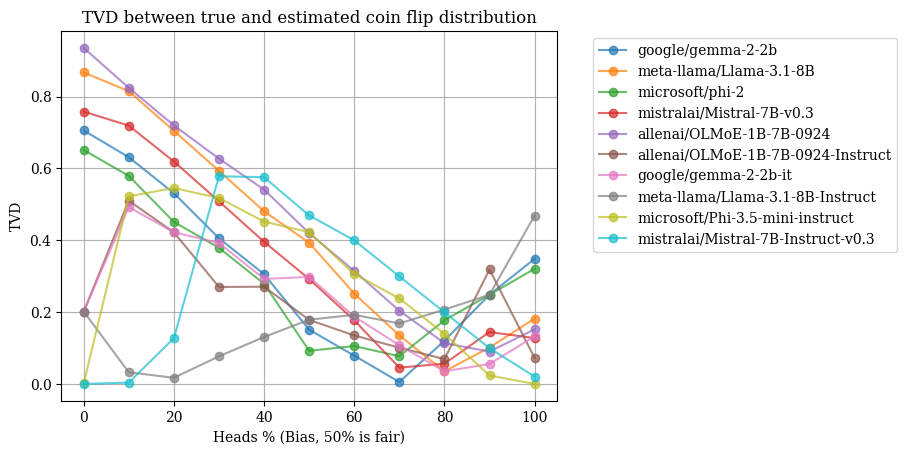

<Figure size 640x480 with 0 Axes>

In [102]:
plt.clf()
for key, data in biased_point_data.items():
    plt.plot([x[0] for x in data], [x[1] for x in data], '-o', label=key.replace('_', '/'), alpha=0.7)

# Add a baseline key: (predicting 50/50 for all biases)
# baseline = [(x, tvd(np.array([0.5, 0.5]), np.array([x / 100, (100 - x) / 100]))) for x in range(0, 101)]
# plt.plot([x[0] for x in baseline], [x[1] for x in baseline], label='Baseline (50/50)', linestyle='--', color='black')

plt.xlabel('Heads % (Bias, 50% is fair)')
plt.ylabel('TVD')
plt.legend(bbox_to_anchor=(1.7, 1))
plt.grid()
plt.title('TVD between true and estimated coin flip distribution')
plt.show()

# Save as pdf.
plt.savefig('coin_flip_tvd_std.pdf', bbox_inches='tight')

# Pivot Tables

In [147]:
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

def gen_data_frame(stats, key):
    # Format data as pandas dataframe.
    data = []

    for (context_len, doc_depth, needle), point_stats in stats[key].items():

        data.append({
            'Context Length': context_len,
            'Depth': doc_depth,
            'TVD': tvd(point_stats['choice_probs'], np.exp(point_stats["expected_dist"])),
            'Needle': needle
        })

    # If unbiased experiment, add a row for 0 context length.
    if key == 'pivot_table':

        # Extract unbiased point data and add it to the dataframe, this is TVD at 0 context length.
        zero_context_tvd = tvd(unbiased_point_data[model_name]['choice_probs'], np.exp(unbiased_point_data[model_name]['expected_dist']))

        # Add new row.
        data.append({
            'Context Length': 0,
            'Depth': 0,
            'TVD': zero_context_tvd,
            'Needle': 'Unbiased'
        })

    df = pd.DataFrame(data)

    return df

def bias_needle_pivot_table(df, model_name, index_axes=['Context Length', 'Depth']):
    """
    Generate experiment output for multiple data points (i.e. context and document depth used.)

    Pivot table code based on: https://github.com/gkamradt/LLMTest_NeedleInAHaystack/blob/main/viz/CreateVizFromLLMTesting.ipynb
    """
    # Extract axes.
    axis1, axis2 = index_axes[0], index_axes[1]

    # Create pivot table to visualize data.
    pivot_table = pd.pivot_table(df, values='TVD', index=index_axes, aggfunc=np.mean).reset_index()
    pivot_table = pivot_table.pivot(index=axis2, columns=axis1, values="TVD")

    # Color map.
    cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#0CD79F", "#EBB839", "#F0496E"])

    # Create the heatmap with better aesthetics
    plt.clf()
    ax = sns.heatmap(
        pivot_table,
        # annot=True,
        fmt="g",
        cmap=cmap,
        # cbar_kws={'label': 'TVD'},
        # vmin=0.0,
        # vmax=1.0
    )
    ax.collections[0].colorbar.ax.tick_params(labelsize=18)  # Increase the font size of the colorbar labels

    # More aesthetics
    # plt.title(f'Pivot table for {model_name} indexed over {index_axes}')  # Adds a title
    # plt.xlabel(axis1)  # X-axis label
    # plt.ylabel(axis2)  # Y-axis label
    # plt.xticks(rotation=45)  # Rotates the x-axis labels to prevent overlap
    # plt.yticks(rotation=0)  # Ensures the y-axis labels are horizontal
    # plt.tight_layout()  # Fits everything neatly into the figure area
    plt.title(f'{model_name.replace("_", "/")}', fontsize=25)  # Adds a title
    plt.xlabel(axis1, fontsize=24)  # X-axis label
    plt.ylabel(axis2, fontsize=24)  # Y-axis label
    plt.xticks(rotation=45)  # Rotates the x-axis labels to prevent overlap
    plt.yticks(rotation=0)  # Ensures the y-axis labels are horizontal
    plt.tight_layout()  # Fits everything neatly into the figure area
    plt.savefig(f'{model_name}_context_pivot_table.pdf', bbox_inches='tight')


def bias_needle_pivot_table_sort(df, model_name, index_axes=['Context Length', 'Depth']):
    """
    Generate experiment output for multiple data points (i.e. context and document depth used.)

    Pivot table code based on: https://github.com/gkamradt/LLMTest_NeedleInAHaystack/blob/main/viz/CreateVizFromLLMTesting.ipynb
    """
    # Extract axes.
    axis1, axis2 = index_axes[0], index_axes[1]

    # Function to extract percentage from strings in axis2
    def extract_percentage(text):
        match = re.search(r'(\d+)%', text)  # Look for digits followed by a '%'
        if match:
            return int(match.group(1))  # Convert the matched percentage to an integer
        return None  # Return None if no percentage is found

    # Apply the function to the axis2 column
    df['percentage'] = df[axis2].apply(extract_percentage)

    # Drop rows with missing percentage if needed
    df = df.dropna(subset=['percentage'])

    index_axes[1] = 'percentage'  # Update axis2 to use the extracted percentage
    axis2 = 'percentage'  # Update axis2 to use the extracted percentage

    # Create pivot table to visualize data.
    pivot_table = pd.pivot_table(df, values='TVD', index=index_axes, aggfunc=np.mean).reset_index()
    pivot_table = pivot_table.pivot(index=axis2, columns=axis1, values="TVD")

    # Color map.
    cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#0CD79F", "#EBB839", "#F0496E"])

    # Create the heatmap with better aesthetics
    plt.clf()
    ax = sns.heatmap(
        pivot_table,
        # annot=True,
        fmt="g",
        cmap=cmap,
        vmin=0.0,
        vmax=1.0,
    )
    ax.collections[0].colorbar.ax.tick_params(labelsize=18)  # Increase the font size of the colorbar labels


    # More aesthetics
    plt.title(f'{model_name.replace("_", "/")}', fontsize=25)  # Adds a title
    plt.xlabel('Context Length', fontsize=24)  # X-axis label
    plt.ylabel('Bias %', fontsize=24)  # Y-axis label
    plt.xticks(rotation=45)  # Rotates the x-axis labels to prevent overlap
    plt.yticks(rotation=0)  # Ensures the y-axis labels are horizontal
    plt.tight_layout()  # Fits everything neatly into the figure area
    plt.savefig(f'{model_name}_needle_pivot_table.pdf', bbox_inches='tight')

def unbiased_exp_plot(df_data, unbiased_point_data):
    """
    Generate unbiased experiments plot.
    """
    # Create the plot
    plt.figure(figsize=(17.5, 8))  # Can adjust these dimensions as needed

    # Iterate over each model.
    for model_name, data in df_data.items():

        # Extract TVD and STD.
        model_tvd = data['unbiased_df'].groupby(['Context Length', 'Depth', 'Needle']).mean().reset_index()
        model_std = data['unbiased_df'].groupby(['Context Length', 'Depth', 'Needle']).std().reset_index()

        # Plot the data.
        plt.plot(model_tvd['Context Length'], model_tvd['TVD'], label=f'{model_name} - TVD', alpha=0.7)

        # Fill between the standard deviation.
        plt.fill_between(
            model_tvd['Context Length'],
            model_tvd['TVD'] - model_std['TVD'],
            model_tvd['TVD'] + model_std['TVD'],
            alpha=0.2
        )

    # # More aesthetics
    plt.title('Unbiased Experiments')  # Adds a title
    plt.xlabel('Token Limit')  # X-axis label
    plt.ylabel('TVD')  # Y-axis label
    plt.xticks(rotation=45)  # Rotates the x-axis labels to prevent overlap
    plt.yticks(rotation=0)  # Ensures the y-axis labels are horizontal
    plt.legend()  # Adds a legend
    plt.tight_layout()  # Fits everything neatly into the figure area
    plt.show()


In [143]:
# Generate data frames for all models.
df_data = {}

for model_name, stats in model_stats_data.items():

    # Generate data frame for both biased and unbiased context experiments.
    unbiased_df = gen_data_frame(stats, 'pivot_table')
    biased_df = gen_data_frame(stats, 'needle_pivot_table')

    df_data[model_name] = {
        'unbiased_df': unbiased_df,
        'biased_df': biased_df
    }

/tmp/ipykernel_1821505/398578979.py:46: FutureWarning: The provided callable <function mean at 0x7a82bc0c3600> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_table = pd.pivot_table(df, values='TVD', index=index_axes, aggfunc=np.mean).reset_index()
/tmp/ipykernel_1821505/398578979.py:107: FutureWarning: The provided callable <function mean at 0x7a82bc0c3600> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_table = pd.pivot_table(df, values='TVD', index=index_axes, aggfunc=np.mean).reset_index()
/tmp/ipykernel_1821505/398578979.py:46: FutureWarning: The provided callable <function mean at 0x7a82bc0c3600> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To

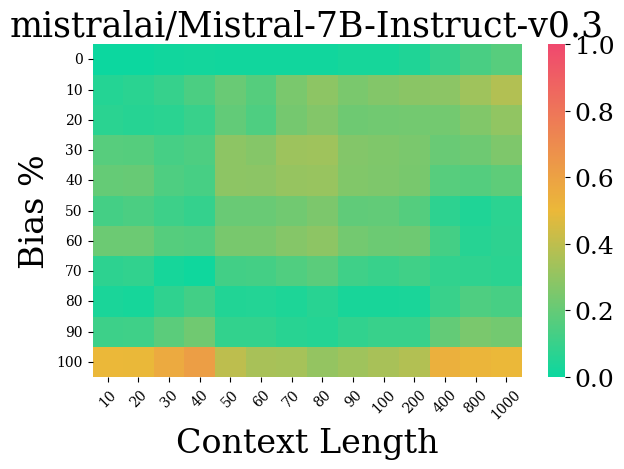

In [148]:

# Generate biase needle pivot tables.
for model_name, data in df_data.items():
    bias_needle_pivot_table(data['biased_df'], model_name)
    bias_needle_pivot_table_sort(data['biased_df'], model_name, index_axes=['Context Length', 'Needle'])

In [4]:
# Stats PKL files
# /home/davidchan/Repos/random_needles/exps/contextual/coin_flip_icl_v2/icl_1/10/google_gemma-2-2b/stats.pkl

# model_map = {
#     'google/Gemma-2-2B': '../exps/contextual/coin_flip_icl_v2/icl_{icl_length}/{bias}/google_gemma-2-2b/stats.pkl',
#     'google/Gemma-2-2B-IT': '../exps/contextual/coin_flip_icl_v2/icl_{icl_length}/{bias}/google_gemma-2-2b-it/stats.pkl',
#     'meta-llama/Llama-3.1-8B': '../exps/contextual/coin_flip_icl_v2/icl_{icl_length}/{bias}/meta-llama_Llama-3.1-8B/stats.pkl',
#     'meta-llama/Llama-3.1-8B-Instruct': '../exps/contextual/coin_flip_icl_v2/icl_{icl_length}/{bias}/meta-llama_Llama-3.1-8B-Instruct/stats.pkl',
#     'microsoft/Phi-3.5-mini-instruct': '../exps/contextual/coin_flip_icl_v2/icl_{icl_length}/{bias}/microsoft_Phi-3.5-mini-instruct/stats.pkl',
# }

sizes = [
    '70m',
    '160m',
    '410m',
    '1b',
    '1.4b',
    '2.8b',
    '6.9b',
    '12b'
]

model_map = {}

for size in sizes:
    model_map[f'EleutherAI/pythia-{size}-deduped'] = "../exps/contextual/coin_flip_icl_v2/icl_{icl_length}/{bias}" + f'/EleutherAI_pythia-{size}-deduped/stats.pkl'

In [9]:
# Explore a ICL file
icl_length = 1
bias = 10

icl_file = model_map['EleutherAI/pythia-12b-deduped'].format(icl_length=icl_length, bias=bias)
with open(icl_file, 'rb') as f:
    icl_data = pickle.load(f)

icl_data.keys()

dict_keys(['averaged_stats', 'stats_over_prompts'])

In [10]:
icl_data['averaged_stats']['biased_point']['When I flip coins they land on heads 10% of the time.']['tvd']['mean']

0.811574694365263

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

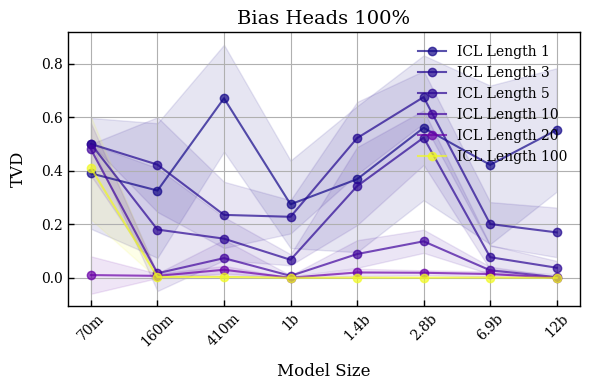

In [31]:
models_in_order = [
    'EleutherAI/pythia-70m-deduped',
    'EleutherAI/pythia-160m-deduped',
    'EleutherAI/pythia-410m-deduped',
    'EleutherAI/pythia-1b-deduped',
    'EleutherAI/pythia-1.4b-deduped',
    'EleutherAI/pythia-2.8b-deduped',
    'EleutherAI/pythia-6.9b-deduped',
    'EleutherAI/pythia-12b-deduped'
]

model_sizes = [
    '70m',
    '160m',
    '410m',
    '1b',
    '1.4b',
    '2.8b',
    '6.9b',
    '12b'
]

# model = 'google/Gemma-2-2B'
# model = 'meta-llama/Llama-3.1-8B'

all_data = {
    'model_sizes': model_sizes
}



for bias in (0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100):
    
    data = defaultdict(list)
    all_data[f'bias_{bias}'] = defaultdict(list)
    
    for icl_length in (1,3,5,10,20,100):
        for i, model in enumerate(models_in_order):
            icl_file = model_map[model].format(icl_length=icl_length, bias=bias)
            if not os.path.exists(icl_file):
                continue
            with open(icl_file, 'rb') as f:
                icl_data = pickle.load(f)
            data[icl_length].append((
                i,
                icl_data['averaged_stats']['biased_point'][f'When I flip coins they land on heads {bias}% of the time.']['tvd']['mean'],
                icl_data['averaged_stats']['biased_point'][f'When I flip coins they land on heads {bias}% of the time.']['tvd']['std']
            ))
            
            # For data storage. 
            all_data[f'bias_{bias}'][f'icl_len_{icl_length}'].append({
                'model_idx': i, 
                'tvd_mean': icl_data['averaged_stats']['biased_point'][f'When I flip coins they land on heads {bias}% of the time.']['tvd']['mean'],
                'tvd_std': icl_data['averaged_stats']['biased_point'][f'When I flip coins they land on heads {bias}% of the time.']['tvd']['std']
            })

    plt.clf()
    plt.figure()
    for icl_length, values in data.items():
        plt.plot([x[0] for x in values], [x[1] for x in values], '-o', label=f'ICL Length {icl_length}',  alpha=0.7, color=plt.cm.plasma(icl_length / 100))
        plt.fill_between([x[0] for x in values], [x[1] - x[2] for x in values], [x[1] + x[2] for x in values], alpha=0.1, color=plt.cm.plasma(icl_length / 100))

    plt.xticks(range(len(models_in_order)), model_sizes, rotation=45)
    plt.grid()
    plt.title(f'Bias Heads {bias}%')
    plt.xlabel('Model Size')
    plt.ylabel('TVD')
    plt.tight_layout()
    plt.legend(loc='upper right')
    #plt.savefig(f'{model.replace("/", "_")}_icl_tvd.png', bbox_inches='tight')
    plt.savefig(f'pythia_icl_tvd_{bias}.png', bbox_inches='tight')


import pickle
pickle.dump(all_data, open('pythia_icl_tvd.pkl', 'wb'))

In [ ]:
model = 'meta-llama/Llama-3.1-8B-Instruct'
for model in ['meta-llama/Llama-3.1-8B-Instruct', 'google/Gemma-2-2B-IT', 'microsoft/Phi-3.5-mini-instruct']:
    data = defaultdict(list)
    for icl_length in (1,3,5,10,20,100):
        for bias in (0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100):
            icl_file = model_map[model].format(icl_length=icl_length, bias=bias)
            if not os.path.exists(icl_file):
                continue
            with open(icl_file, 'rb') as f:
                icl_data = pickle.load(f)
            try:
                data[icl_length].append((
                    bias,
                    icl_data['averaged_stats']['biased_point'][f'When you flip coins, they land on heads {bias}% of the time.']['tvd']['mean'],
                    icl_data['averaged_stats']['biased_point'][f'When you flip coins, they land on heads {bias}% of the time.']['tvd']['std']
                ))
            except:
                print(icl_file)
                print( icl_data['averaged_stats']['biased_point'].keys())
                continue

    plt.clf()
    plt.figure()
    for icl_length, values in data.items():
        plt.plot([x[0] for x in values], [x[1] for x in values], '-o', label=f'ICL Length {icl_length}',  alpha=0.7, color=plt.cm.plasma(icl_length / 100))
        plt.fill_between([x[0] for x in values], [x[1] - x[2] for x in values], [x[1] + x[2] for x in values], alpha=0.1, color=plt.cm.plasma(icl_length / 100))

    plt.grid()
    plt.title(model)
    plt.xlabel('Bias (% Heads)')
    plt.ylabel('TVD')
    plt.tight_layout()
    plt.legend(loc='upper right')
    plt.savefig(f'{model.replace("/", "_")}_icl_tvd.pdf', bbox_inches='tight')

KeyError: 'meta-llama/Llama-3.1-8B-Instruct'

<Figure size 600x400 with 0 Axes>

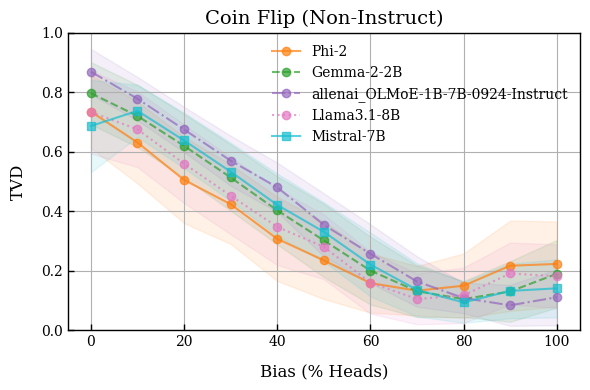

In [33]:
# Plot all models
import glob
import itertools
root_dir = '../exps/contextual/coin_flip_multiset'

# Discover all folders in the root directory
folders = glob.glob(f'{root_dir}/*')

# Extract model names
model_names = [folder.split('/')[-1] for folder in folders]

# Load all stats
data = defaultdict(list)
for model_name in model_names:
    stats_file = f'{root_dir}/{model_name}/stats.pkl'
    if not os.path.exists(stats_file):
        continue
    with open(stats_file, 'rb') as f:
        model_stats_data[model_name] = pickle.load(f)
    model_is_instruct = 'it' in model_name.lower() or 'instruct' in model_name.lower()
    for bias in (0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100):
        if model_is_instruct:
            key = f'When you flip coins, they land on heads {bias}% of the time.'
        else:
            key = f'When I flip coins they land on heads {bias}% of the time.'
        try:
            data[model_name].append((
                bias,
                model_is_instruct,
                model_stats_data[model_name]['averaged_stats']['biased_point'][key]['tvd']['mean'],
                model_stats_data[model_name]['averaged_stats']['biased_point'][key]['tvd']['std']
            ))
        except:
            print(model_name)
            print(model_stats_data[model_name]['averaged_stats']['biased_point'].keys())
            continue

# Plot non-instruct models
plt.clf()
plt.figure()
linestyles = itertools.cycle(['-o', '--o', '-.o', ':o', '-s', '--s', '-.s', ':s', '-^', '--^', '-.^', ':^'])
for i, (model_name, values) in enumerate(data.items()):
    if not values[0][1]:
        color = plt.cm.tab10(i)
        if 'MicroLlama' in model_name:
            continue

        plt.plot([x[0] for x in values], [x[2] for x in values], next(linestyles), label=model_map[model_name],  alpha=0.7, color=color)
        plt.fill_between([x[0] for x in values], [x[2] - x[3] for x in values], [x[2] + x[3] for x in values], alpha=0.1, color=color)

plt.grid()
plt.title('Coin Flip (Non-Instruct)')
plt.xlabel('Bias (% Heads)')
plt.ylabel('TVD')
plt.ylim(0,1)
plt.tight_layout()
plt.legend(loc='upper right')
plt.savefig('coin_flip_non_instruct.pdf', bbox_inches='tight')


KeyError: 'allenai_OLMoE-1B-7B-0924-Instruct'

<Figure size 600x400 with 0 Axes>

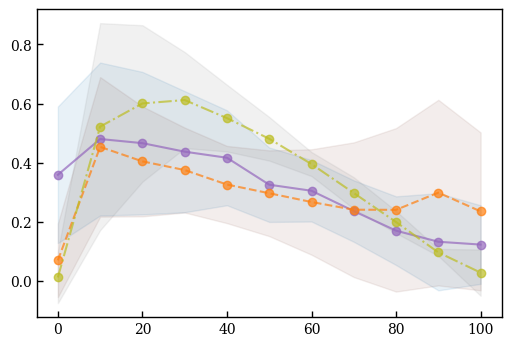

In [47]:
# Plot all models
import glob
import itertools
root_dir = '../exps/contextual/coin_flip_multiset'

# Discover all folders in the root directory
folders = glob.glob(f'{root_dir}/*')

# Extract model names
model_names = [folder.split('/')[-1] for folder in folders]

# Load all stats
data = defaultdict(list)
for model_name in model_names:
    stats_file = f'{root_dir}/{model_name}/stats.pkl'
    if not os.path.exists(stats_file):
        continue
    with open(stats_file, 'rb') as f:
        model_stats_data[model_name] = pickle.load(f)
    model_is_instruct = 'it' in model_name.lower() or 'instruct' in model_name.lower()
    for bias in (0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100):
        if model_is_instruct:
            key = f'When you flip coins, they land on heads {bias}% of the time.'
        else:
            key = f'When I flip coins they land on heads {bias}% of the time.'
        try:
            data[model_name].append((
                bias,
                model_is_instruct,
                model_stats_data[model_name]['averaged_stats']['biased_point'][key]['tvd']['mean'],
                model_stats_data[model_name]['averaged_stats']['biased_point'][key]['tvd']['std']
            ))
        except:
            print(model_name)
            print(model_stats_data[model_name]['averaged_stats']['biased_point'].keys())
            continue

# Plot non-instruct models
plt.clf()
plt.figure()
linestyles = itertools.cycle(['-o', '--o', '-.o', ':o', '-s', '--s', '-.s', ':s', '-^', '--^', '-.^', ':^'])
for i, (model_name, values) in enumerate(data.items()):
    if values[0][1]:
        color = plt.cm.tab10(i)

        plt.plot([x[0] for x in values], [x[2] for x in values], next(linestyles), label=model_map[model_name],  alpha=0.7, color=model_color_map[model_name])
        plt.fill_between([x[0] for x in values], [x[2] - x[3] for x in values], [x[2] + x[3] for x in values], alpha=0.1, color=color)

plt.grid()
plt.ylim(0, 1)
plt.title('Coin-Flip (Instruct)')
plt.xlabel('Bias (% Heads)')
plt.ylabel('TVD')
plt.tight_layout()
plt.legend(loc='upper right')
plt.savefig('coin_flip_instruct.pdf', bbox_inches='tight')
